In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

/Users/davideposillipo/anaconda3/envs/pymc3_DSR/lib/python3.6/site-packages/matplotlib/font_manager.py:232: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


In [45]:
from pymc3 import (Model, DiscreteUniform, Exponential,  
Poisson, Deterministic, sample, traceplot, summary)
from pymc3.math import switch

In [2]:
disasters_data = np.array([4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
                         3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
                         2, 2, 3, 4, 2, 1, 3, 2, 2, 1, 1, 1, 1, 3, 0, 0,
                         1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
                         0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
                         3, 3, 1, 1, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
                         0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1])

In [3]:
# From 1851 to 1962
n_years = len(disasters_data)
n_years

111

(1851, 1962)

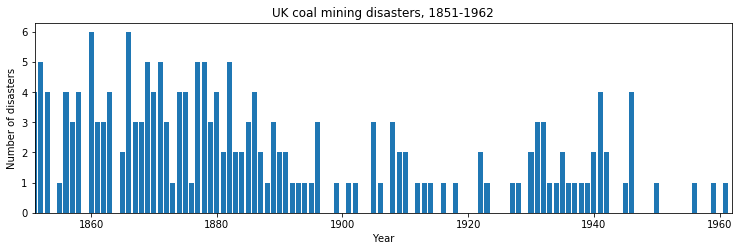

In [4]:
plt.figure(figsize=(12.5, 3.5))
plt.bar(np.arange(1851, 1962), disasters_data)
plt.xlabel('Year')
plt.ylabel('Number of disasters')
plt.title('UK coal mining disasters, 1851-1962')
plt.xlim(1851, 1962)

### Priors definition

In [6]:
# Defining the unknown switchpoint as a discrete uniform random variable

with Model() as disaster_model:
    
    switchpoint = DiscreteUniform('switchpoint', lower=0, upper=n_years)

In [7]:
# other possible discrete distributions we could use 
from pymc3.distributions import discrete
discrete.__all__

['Binomial',
 'BetaBinomial',
 'Bernoulli',
 'DiscreteWeibull',
 'Poisson',
 'NegativeBinomial',
 'ConstantDist',
 'Constant',
 'ZeroInflatedPoisson',
 'ZeroInflatedBinomial',
 'ZeroInflatedNegativeBinomial',
 'DiscreteUniform',
 'Geometric',
 'Categorical',
 'OrderedLogistic']

In [10]:
# Defining the early and late Poisson rates

with disaster_model:
    
    early_mean = Exponential('early_mean', 1)
    late_mean = Exponential('late_mean', 1)

In [15]:
# Exponential distribution are auto transformed -> https://docs.pymc.io/Probability_Distributions.html#auto-transformation
# "To aid efficient MCMC sampling, any continuous variables that are constrained to a sub-interval of 
# the real line are automatically transformed so that their support is unconstrained. 
# This frees sampling algorithms from having to deal with boundary constraints."
disaster_model.vars

[switchpoint, early_mean_log__, late_mean_log__]

In [16]:
# The original variable is stored in the deterministic variables list 
disaster_model.deterministics

[early_mean, late_mean]

In [24]:
# Defining the rate variable, using the Pymc3 'switch' variable

with disaster_model:
    
    # switch -> if cond then ift else iff
    # We put it inside a Deterministic object in order to give it a name
    rate = Deterministic('rate', switch(switchpoint >= np.arange(n_years), early_mean, late_mean))

### Likelihood definition

In [21]:
# Defining the likelihood function

with disaster_model: 
    
    disasters = Poisson('disasters', mu=rate, observed=disasters_data)

In [25]:
disaster_model.vars

[switchpoint, early_mean_log__, late_mean_log__]

In [26]:
disaster_model.deterministics

[early_mean, late_mean, rate]

### MCMC simulations

In [38]:
with disaster_model:
    trace = sample(5000)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [switchpoint]
>NUTS: [late_mean, early_mean]
Sampling 4 chains: 100%|██████████| 22000/22000 [00:05<00:00, 3850.84draws/s]
The number of effective samples is smaller than 25% for some parameters.


In [39]:
trace

<MultiTrace: 4 chains, 5000 iterations, 6 variables>

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c23ac3048>,
      dtype=object)

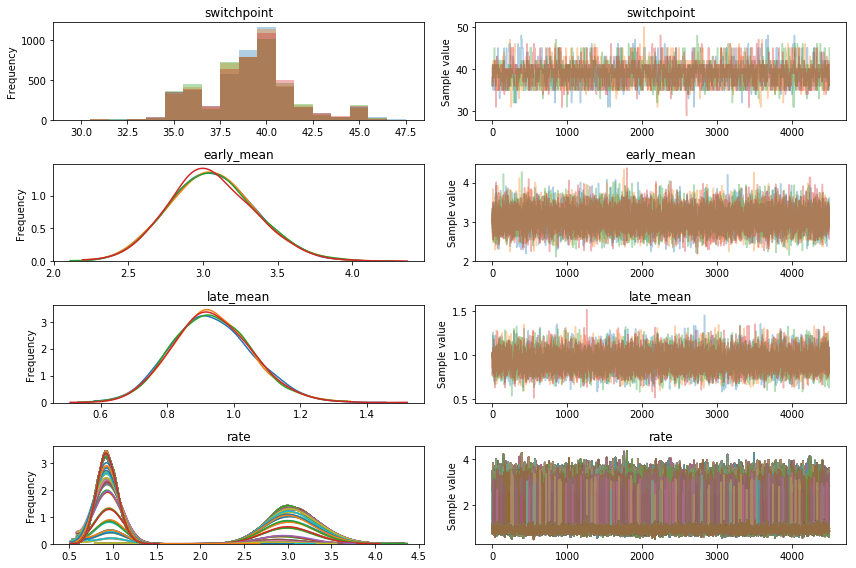

In [43]:
traceplot(trace[500:])

In [47]:
summary(trace[500:], varnames=['switchpoint', 'early_mean', 'late_mean'])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
switchpoint,39.085056,2.455569,0.052039,35.000000,45.000000,1898.512216,1.000054
early_mean,3.063652,0.286391,0.002578,2.523299,3.635391,10875.498707,0.999974
late_mean,0.934863,0.117461,0.001024,0.709905,1.168796,11939.889021,0.999930
